# Introducing: HistFrames
HistFrames are similar to data frames, but each row corresponds to a bin, like in a histogram. They do not aim to be fully featured histogram objects like you might find in other libraries, however. Jack of all trades; master of... also all trades.

`HistFrame`s take a Binning object and an optional column name for the first column.

In [1]:
import pyNUISANCE as pn
hf = pn.HistFrame(pn.Binning.lin_space(0,10,50), "MCPrediction")
print(hf) #the printer only prints the first 20 rows by default

 ----------------------------
 | bin | MCPrediction | err |
 ----------------------------
 |   0 |            0 |   0 |
 |   1 |            0 |   0 |
 |   2 |            0 |   0 |
 |   3 |            0 |   0 |
 |   4 |            0 |   0 |
 |   5 |            0 |   0 |
 |   6 |            0 |   0 |
 |   7 |            0 |   0 |
 |   8 |            0 |   0 |
 |   9 |            0 |   0 |
 |  10 |            0 |   0 |
 |  11 |            0 |   0 |
 |  12 |            0 |   0 |
 |  13 |            0 |   0 |
 |  14 |            0 |   0 |
 |  15 |            0 |   0 |
 |  16 |            0 |   0 |
 |  17 |            0 |   0 |
 |  18 |            0 |   0 |
 |  19 |            0 |   0 |
 |  20 |            0 |   0 |
 |          ... | ... |
 ----------------------------


We can then add an entry to a bin

In [2]:
import pyProSelecta as pps

evs = pn.EventSource("dune_argon_sf_10mega.nuwro.pb.gz")
if not evs:
    print("Error: failed to open input file")

def enu_GeV(ev):
    bpart = pps.sel.Beam(ev,14)
    if not bpart:
        return pn.HistFrame.missing_datum
    return bpart.momentum().e() * 1E-3
    
hf.reset() # reset it so that repeated running of this cell doesn't keep filling the histo
ev, cvw = evs.first()
enu = enu_GeV(ev)
hf.fill(enu, cvw) # for correctly normalizable distributions that work for different generators 
                  # we *always* need to keep track of the weights, even if they're all '1' for 
                  # our testing generator
print(hf)

 ----------------------------
 | bin | MCPrediction | err |
 ----------------------------
 |   0 |            0 |   0 |
 |   1 |            0 |   0 |
 |   2 |            0 |   0 |
 |   3 |            0 |   0 |
 |   4 |            0 |   0 |
 |   5 |            0 |   0 |
 |   6 |            0 |   0 |
 |   7 |            0 |   0 |
 |   8 |            0 |   0 |
 |   9 |            0 |   0 |
 |  10 |            0 |   0 |
 |  11 |            1 |   1 |
 |  12 |            0 |   0 |
 |  13 |            0 |   0 |
 |  14 |            0 |   0 |
 |  15 |            0 |   0 |
 |  16 |            0 |   0 |
 |  17 |            0 |   0 |
 |  18 |            0 |   0 |
 |  19 |            0 |   0 |
 |  20 |            0 |   0 |
 |          ... | ... |
 ----------------------------


Lets make a more sensibly binned histogram and fill it with a few events

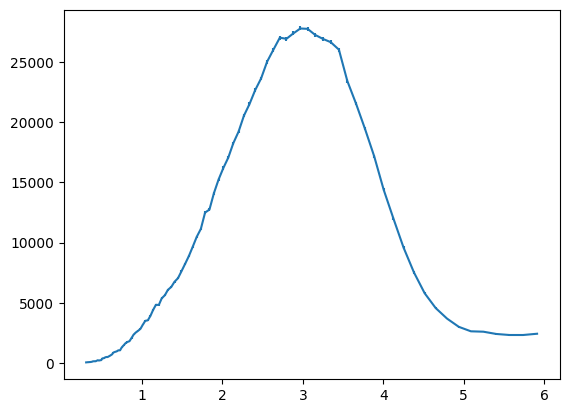

In [3]:
import matplotlib.pyplot as plt
import numpy as np

hf = pn.HistFrame(pn.Binning.log10_space(3E-1,6,100))
for i, (ev, cvw) in enumerate(evs):
    hf.fill(enu_GeV(ev),cvw)
    if i >= 1E6:
        break

plt.errorbar(pn.Binning.get_bin_centers1D(hf.binning.bins),
             hf.contents[:,0],yerr=np.sqrt(hf.variance[:,0]))
plt.show()

## 2D Histograms

As we saw in the [binning notebook](https://github.com/NUISANCEMC/eventinput/blob/main/notebooks/binning.ipynb), we can make multi-dimensional binnings. These can be used to instantiate `HistFrame`s.

In [4]:
hf_ptpz = pn.HistFrame(pn.Binning.lin_spaceND([[0,5,75],[0,1.25,25]], ["pz","pt"]))

In [5]:
def ptpz(ev):
    bpart = pps.sel.Beam(ev,14)
    if not bpart:
        return pn.HistFrame.missing_datum
    beam_pid = bpart.pid()
    cc_lep_pid = (beam_pid - 1) if (beam_pid > 0) else (beam_pid + 1);
    lep = pps.sel.OutPartHM(ev, int(cc_lep_pid))
    if not lep:
        return pn.HistFrame.missing_datum
    
    return [lep.momentum().pz() * 1E-3, lep.momentum().pt() * 1E-3]

In [6]:
hf_ptpz.reset()
for i, (ev, cvw) in enumerate(evs):
    ev_ptpz = ptpz(ev)
    if ev_ptpz != pn.HistFrame.missing_datum:
        hf_ptpz.fill(ev_ptpz,cvw)
    if i >= 1E6:
        break

print(hf_ptpz)

 ---------------------
 | bin |  mc |   err |
 ---------------------
 |   0 | 249 | 15.78 |
 |   1 | 196 |    14 |
 |   2 | 107 | 10.34 |
 |   3 |  86 | 9.274 |
 |   4 |  82 | 9.055 |
 |   5 |  53 |  7.28 |
 |   6 |  67 | 8.185 |
 |   7 |  52 | 7.211 |
 |   8 |  68 | 8.246 |
 |   9 |  58 | 7.616 |
 |  10 |  51 | 7.141 |
 |  11 |  40 | 6.325 |
 |  12 |  51 | 7.141 |
 |  13 |  48 | 6.928 |
 |  14 |  50 | 7.071 |
 |  15 |  49 |     7 |
 |  16 |  51 | 7.141 |
 |  17 |  44 | 6.633 |
 |  18 |  54 | 7.348 |
 |  19 |  64 |     8 |
 |  20 |  49 |     7 |
 | ... |   ... |
 ---------------------


Drawing a 2D histogram is a little more fiddly in matplotlib (or plotly for that matter)

From [numpy.histogram2d](https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html) and [matplotlib.pyplot.pcolormesh](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.pcolormesh.html):

```
(X[i+1, j], Y[i+1, j])       (X[i+1, j+1], Y[i+1, j+1])
                      ●╶───╴●
                      │     │
                      ●╶───╴●
    (X[i, j], Y[i, j])       (X[i, j+1], Y[i, j+1])
```

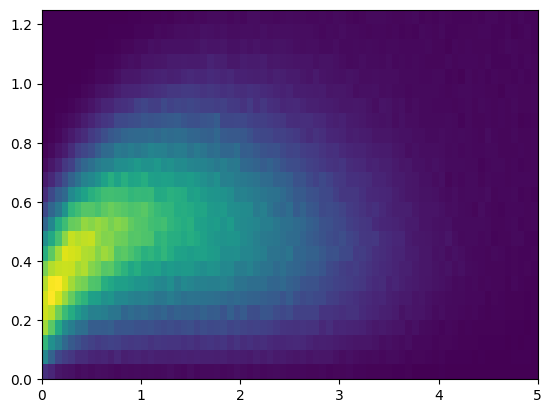

In [7]:
nbins = len(hf_ptpz.binning.bins)
X = np.zeros((2*nbins,2))
Y = np.zeros((2*nbins,2))
C = np.zeros(((2*nbins)-1,1))
for i,bin in enumerate(hf_ptpz.binning.bins):
    X[2*i,0] = bin[0].min
    Y[2*i,0] = bin[1].min
    
    X[2*i + 1,0] = bin[0].min
    Y[2*i + 1,0] = bin[1].max
    
    X[2*i, 1] = bin[0].max
    Y[2*i, 1] = bin[1].min

    X[2*i + 1, 1] = bin[0].max
    Y[2*i + 1, 1] = bin[1].max

    C[2*i,0] = hf_ptpz.contents[i,0]
    if (2*i + 2) != (2*nbins):
        C[2*i + 1,0] = hf_ptpz.contents[i,0]
        
plt.pcolormesh(X, Y, C)
plt.show()

we provide a helper function for building the pcolormesh data structures following the above logic

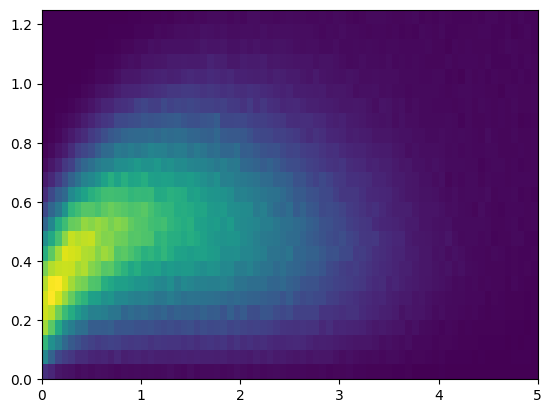

In [8]:
pcmdata = pn.matplotlib.to_pcolormesh_data(hf_ptpz)
plt.pcolormesh(pcmdata["X"], pcmdata["Y"], pcmdata["C"])
plt.show()

## Projections
For rectangular binnings where projections onto lower dimensions are well defined, we can make histogram projections

In [9]:
hf_pt = pn.HistFrame.project(hf_ptpz,1)
print(hf_pt.binning)
print(hf_pt)
print("nfills: %s" % hf_pt.nfills)

Axis lables: ["pt"]
Bins: [
  0: [(0.00 - 0.05)]
  1: [(0.05 - 0.10)]
  2: [(0.10 - 0.15)]
  3: [(0.15 - 0.20)]
  4: [(0.20 - 0.25)]
  5: [(0.25 - 0.30)]
  6: [(0.30 - 0.35)]
  7: [(0.35 - 0.40)]
  8: [(0.40 - 0.45)]
  9: [(0.45 - 0.50)]
  10: [(0.50 - 0.55)]
  11: [(0.55 - 0.60)]
  12: [(0.60 - 0.65)]
  13: [(0.65 - 0.70)]
  14: [(0.70 - 0.75)]
  15: [(0.75 - 0.80)]
  16: [(0.80 - 0.85)]
  17: [(0.85 - 0.90)]
  18: [(0.90 - 0.95)]
  19: [(0.95 - 1.00)]
  20: [(1.00 - 1.05)]
  21: [(1.05 - 1.10)]
  22: [(1.10 - 1.15)]
  23: [(1.15 - 1.20)]
  24: [(1.20 - 1.25)]
]

 ---------------------------
 | bin |        mc |   err |
 ---------------------------
 |   0 |      2913 | 53.97 |
 |   1 |      9208 | 95.96 |
 |   2 | 1.573e+04 | 125.4 |
 |   3 | 2.338e+04 | 152.9 |
 |   4 | 3.114e+04 | 176.5 |
 |   5 | 3.805e+04 | 195.1 |
 |   6 | 4.404e+04 | 209.8 |
 |   7 | 4.829e+04 | 219.7 |
 |   8 | 5.131e+04 | 226.5 |
 |   9 | 5.128e+04 | 226.4 |
 |  10 | 4.979e+04 | 223.1 |
 |  11 | 4.626e+04 | 21

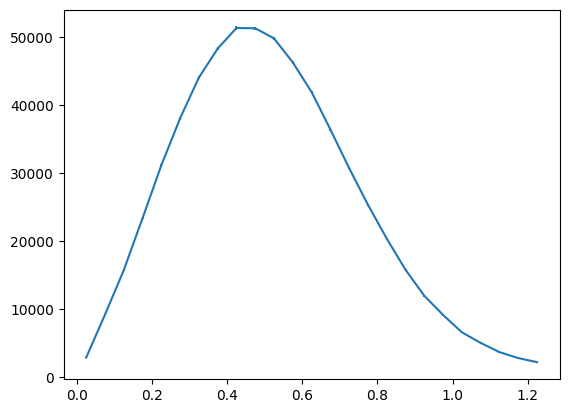

In [10]:
plt.errorbar(pn.Binning.get_bin_centers1D(hf_pt.binning.bins),
             hf_pt.contents[:,0],yerr=np.sqrt(hf_pt.variance[:,0]))
plt.show()

While it is unlikely that we would want to continue calling fill on a projection histogram, it is supported.

In [11]:
hf_pt.fill(0.5,10000)
print(hf_pt)
print("nfills: %s" % hf_pt.nfills)

 ---------------------------
 | bin |        mc |   err |
 ---------------------------
 |   0 |      2913 | 53.97 |
 |   1 |      9208 | 95.96 |
 |   2 | 1.573e+04 | 125.4 |
 |   3 | 2.338e+04 | 152.9 |
 |   4 | 3.114e+04 | 176.5 |
 |   5 | 3.805e+04 | 195.1 |
 |   6 | 4.404e+04 | 209.8 |
 |   7 | 4.829e+04 | 219.7 |
 |   8 | 5.131e+04 | 226.5 |
 |   9 | 5.128e+04 | 226.4 |
 |  10 | 5.979e+04 | 1e+04 |
 |  11 | 4.626e+04 | 215.1 |
 |  12 | 4.191e+04 | 204.7 |
 |  13 | 3.642e+04 | 190.8 |
 |  14 | 3.073e+04 | 175.3 |
 |  15 | 2.535e+04 | 159.2 |
 |  16 | 2.038e+04 | 142.8 |
 |  17 | 1.581e+04 | 125.7 |
 |  18 | 1.199e+04 | 109.5 |
 |  19 |      9172 | 95.77 |
 |  20 |      6633 | 81.44 |
 |       ... |   ... |
 ---------------------------
nfills: 623671


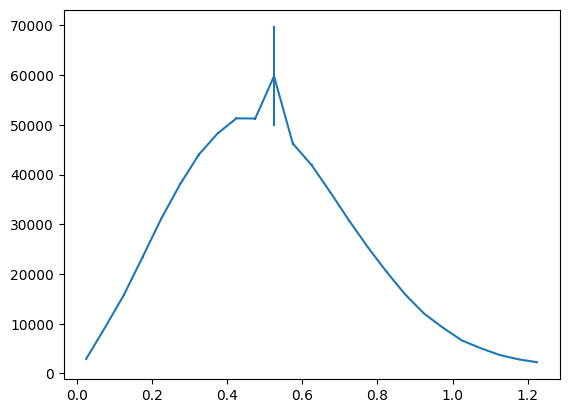

In [12]:
plt.errorbar(pn.Binning.get_bin_centers1D(hf_pt.binning.bins),
             hf_pt.contents[:,0],yerr=np.sqrt(hf_pt.variance[:,0]))
plt.show()